# World Bank API in Python

by Avery Fernandez and Michael T. Moen

> **NOTE:** We currently plan to rewrite this tutorial with more relevant examples.

The World Bank offers a suite of APIs providing access to a vast array of global development data, including economic indicators, project information, and more. These APIs enable users to programmatically retrieve data for analysis, application development, and research purposes.

Please see the following resources for more information on API usage:
- Documentation
    - <a href="https://datahelpdesk.worldbank.org/knowledgebase/articles/889392-about-the-indicators-api-documentation" target="_blank">World Bank Indicators API Documentation</a>
    - <a href="https://datahelpdesk.worldbank.org/knowledgebase/articles/1886698-data-catalog-api" target="_blank">World Bank Data Catalog API Documentation</a>
    - <a href="https://data.worldbank.org/" target="_blank">World Bank Data Catalog</a>
    - <a href="https://datahelpdesk.worldbank.org/knowledgebase/articles/902064-development-best-practices" target="_blank">World Bank Development Best Practices</a>
- Terms
    - <a href="https://www.worldbank.org/en/about/legal/terms-and-conditions#:~:text=You%20may%20not%20use%20the,your%20use%20of%20the%20APIs." target="_blank">World Bank Terms of Use</a>
    - <a href="https://data.worldbank.org/summary-terms-of-use" target="_blank">World Bank Summary Terms of Use</a>
- Data Reuse
    - <a href="https://www.worldbank.org/en/about/legal/terms-of-use-for-datasets" target="_blank">World Bank Data Licensing and Terms of Use</a>

*These recipe examples were tested on September 5, 2025.*

## Setup

### Import Libraries

The following external libraries need to be installed into your enviornment to run the code examples in this tutorial:
* <a href="https://github.com/psf/requests" target="_blank">requests</a>
* <a href="https://github.com/ipython/ipykernel" target="_blank">ipykernel</a>
* <a href="https://github.com/matplotlib/matplotlib" target="_blank">matplotlib</a>

We import the libraries used in this tutorial below:

In [1]:
import requests
import matplotlib.pyplot as plt
from time import sleep

### DataBank Bulk Download

The World Bank offers bulk downloads of specific datasets from <a href="https://databank.worldbank.org/home.aspx" target="_blank">DataBank Bulk Download</a> or <a href="https://microdata.worldbank.org/index.php/home" target="_blank">DataBank Bulk Microdata Download</a>. If you require extensive or complete data, consider using these bulk downloads. For smaller requests or interactive analysis, the standard API calls work well.

## 1. Get Two-Letter Codes for Every Country

The International Organization for Standardization (ISO) maintains a list of two-letter country codes (e.g. CA for Canada, DE for Germany, US for the United States of America). This standard is known as [ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2). These codes are vital for accessing data from specific countries using the World Bank API. These codes are referred to as `iso2Code` in the API.

To begin, we retrieve the `iso2Code` from every available country in the World Bank API.

In [2]:
BASE_URL = "http://api.worldbank.org/v2/country"
params = {
    "format": "json",
    "per_page": 500,
}
response = requests.get(BASE_URL, params=params)

# Status code 200 indicates success
response

<Response [200]>

In [3]:
# Extract data from response and find number of countries
country_data = response.json()[1]
print(f"Found {len(country_data)} countries")

Found 296 countries


In [4]:
# Print data from the first result (Aruba)
country_data[0]

{'id': 'ABW',
 'iso2Code': 'AW',
 'name': 'Aruba',
 'region': {'id': 'LCN',
  'iso2code': 'ZJ',
  'value': 'Latin America & Caribbean '},
 'adminregion': {'id': '', 'iso2code': '', 'value': ''},
 'incomeLevel': {'id': 'HIC', 'iso2code': 'XD', 'value': 'High income'},
 'lendingType': {'id': 'LNX', 'iso2code': 'XX', 'value': 'Not classified'},
 'capitalCity': 'Oranjestad',
 'longitude': '-70.0167',
 'latitude': '12.5167'}

This is just a list of data for the countries. We want to extract the iso2code for each country and also the name of the country.

In [5]:
# Use dictionary comprehension to extract iso2Codes and country names into a dictionary
country_iso2Code = {country["name"]: country["iso2Code"] for country in country_data}

country_iso2Code

{'Aruba': 'AW',
 'Africa Eastern and Southern': 'ZH',
 'Afghanistan': 'AF',
 'Africa': 'A9',
 'Africa Western and Central': 'ZI',
 'Angola': 'AO',
 'Albania': 'AL',
 'Andorra': 'AD',
 'Arab World': '1A',
 'United Arab Emirates': 'AE',
 'Argentina': 'AR',
 'Armenia': 'AM',
 'American Samoa': 'AS',
 'Antigua and Barbuda': 'AG',
 'Australia': 'AU',
 'Austria': 'AT',
 'Azerbaijan': 'AZ',
 'Burundi': 'BI',
 'East Asia & Pacific (IBRD-only countries)': 'B4',
 'Europe & Central Asia (IBRD-only countries)': 'B7',
 'Belgium': 'BE',
 'Benin': 'BJ',
 'Burkina Faso': 'BF',
 'Bangladesh': 'BD',
 'Bulgaria': 'BG',
 'IBRD countries classified as high income': 'B1',
 'Bahrain': 'BH',
 'Bahamas, The': 'BS',
 'Bosnia and Herzegovina': 'BA',
 'Latin America & the Caribbean (IBRD-only countries)': 'B2',
 'Belarus': 'BY',
 'Belize': 'BZ',
 'Middle East, North Africa, Afghanistan & Pakistan (IBRD only)': 'B3',
 'Bermuda': 'BM',
 'Bolivia': 'BO',
 'Brazil': 'BR',
 'Barbados': 'BB',
 'Brunei Darussalam': 'BN'

## 2. Comparing Economic Indicators between Two Countries

In this section, we will fetch data for multiple countries across multiple years and visualize the results. We’ll demonstrate how to:
1. Send multiple API requests (or page through a single request if needed).
2. Parse the returned data into a structured format.
3. Visualize the GDP data using `matplotlib`.

See the <a href="https://data.worldbank.org/indicator" target="_blank">World Bank site</a> for a list of indicators.

We will select three indicators for this example:

1. Scientific and Technical Journal Article Data = <a href="https://data.worldbank.org/indicator/IP.JRN.ARTC.SC?view=chart" target="_blank">IP.JRN.ARTC.SC</a>

2. Patent Applications, residents = <a href="https://data.worldbank.org/indicator/IP.PAT.RESD?view=chart" target="_blank">IP.PAT.RESD</a>

3. GDP per capita (current US$) Code = <a href="https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?view=chart" target="_blank">NY.GDP.PCAP.CD</a>

Note that these three selected indicators have a <a href="https://datacatalog.worldbank.org/public-licenses#cc-by" target="_blank">CC-BY 4.0 license</a>. We will compile this indicator data for the United States (US) and United Kingdom (GB).

In [6]:
indicators = ['IP.JRN.ARTC.SC','IP.PAT.RESD','NY.GDP.PCAP.CD']

# Extract iso2Codes from previous results
US_ISO2CODE = country_iso2Code['United States']
UK_ISO2CODE = country_iso2Code['United Kingdom']

# Display results of lookup
US_ISO2CODE, UK_ISO2CODE

('US', 'GB')

Now we want to compile the data for the three indicators for the United States (US) and United Kingdom (GB).

In [7]:
US_indicator_data = {}
UK_indicator_data = {}
http_params = {
    "format": "json",
    "per_page": 500,
}

for indicator in indicators:
    try:
        response = requests.get(
            f"{BASE_URL}/{US_ISO2CODE}/indicator/{indicator}", 
            params=http_params
        )
        sleep(1)
        response.raise_for_status()
        US_indicator_data[indicator] = response.json()
        print(f"Successfully retrieved data for {indicator} for {US_ISO2CODE}")
    except requests.exceptions.RequestException as e:
        print(f"Error for {indicator} for {US_ISO2CODE}: {e}")
        US_indicator_data[indicator] = []
    
    try:
        response = requests.get(
            f"{BASE_URL}/{UK_ISO2CODE}/indicator/{indicator}",
            params=http_params
        )
        sleep(1)
        response.raise_for_status()
        UK_indicator_data[indicator] = response.json()
        print(f"Successfully retrieved data for {indicator} for {UK_ISO2CODE}")
    except requests.exceptions.RequestException as e:
        print(f"Error for {indicator} for {UK_ISO2CODE}: {e}")
        UK_indicator_data[indicator] = []

Successfully retrieved data for IP.JRN.ARTC.SC for US
Successfully retrieved data for IP.JRN.ARTC.SC for GB
Successfully retrieved data for IP.PAT.RESD for US
Successfully retrieved data for IP.PAT.RESD for GB
Successfully retrieved data for NY.GDP.PCAP.CD for US
Successfully retrieved data for NY.GDP.PCAP.CD for GB


In [8]:
# Print first 3 entries in 'Scientific and Technical Journal Article Data'
US_indicator_data['IP.JRN.ARTC.SC'][1][:3]

[{'indicator': {'id': 'IP.JRN.ARTC.SC',
   'value': 'Scientific and technical journal articles'},
  'country': {'id': 'US', 'value': 'United States'},
  'countryiso3code': 'USA',
  'date': '2024',
  'value': None,
  'unit': '',
  'obs_status': '',
  'decimal': 0},
 {'indicator': {'id': 'IP.JRN.ARTC.SC',
   'value': 'Scientific and technical journal articles'},
  'country': {'id': 'US', 'value': 'United States'},
  'countryiso3code': 'USA',
  'date': '2023',
  'value': None,
  'unit': '',
  'obs_status': '',
  'decimal': 0},
 {'indicator': {'id': 'IP.JRN.ARTC.SC',
   'value': 'Scientific and technical journal articles'},
  'country': {'id': 'US', 'value': 'United States'},
  'countryiso3code': 'USA',
  'date': '2022',
  'value': 457335.25,
  'unit': '',
  'obs_status': '',
  'decimal': 0}]

Now we need to extract the data and compile for analysis for both the United States and United Kingdom.
- Key: Year
- Column 1: Scientific and Technical Journal Article Data = `IP.JRN.ARTC.SC`
- Column 2: Patent Applications, residents = `IP.PAT.RESD`
- Column 3: GDP per capita (current US$) Code = `NY.GDP.PCAP.CD`

In [9]:
US_data = {}
UK_data = {}

for indicator in indicators:
    if US_indicator_data[indicator]:
        for record in US_indicator_data[indicator][1]:
            year = int(record["date"])
            value = float(record["value"] or 'nan')
            if year not in US_data:
                US_data[year] = []
            US_data[year].append(value)
    if UK_indicator_data[indicator]:
        for record in UK_indicator_data[indicator][1]:
            year = int(record["date"])
            value = float(record["value"] or 'nan')
            if year not in UK_data:
                UK_data[year] = []            
            UK_data[year].append(value)

In [10]:
# Print the raw structure of the US data
US_data

{2024: [nan, nan, 85809.9003846356],
 2023: [nan, nan, 82304.6204272866],
 2022: [457335.25, nan, 77860.9112908848],
 2021: [472448.44, 262244.0, 71307.4017277218],
 2020: [457586.9, 269586.0, 64401.5074354212],
 2019: [451480.17, 285113.0, 65227.9565911038],
 2018: [447164.41, 285095.0, 62875.6661382728],
 2017: [440417.99, 293904.0, 60047.7190728307],
 2016: [437546.04, 295327.0, 57976.628204291],
 2015: [436908.38, 288335.0, 56849.4697923159],
 2014: [434412.33, 285096.0, 55153.3940182967],
 2013: [432033.06, 287831.0, 53297.3862901595],
 2012: [430163.93, 268782.0, 51708.3940614082],
 2011: [426831.73, 247750.0, 50024.8812320773],
 2010: [413704.71, 241977.0, 48642.6312088213],
 2009: [404007.54, 224912.0, 47194.9500893872],
 2008: [399273.41, 231588.0, 48570.0594269601],
 2007: [396306.1, 241347.0, 48050.227412195],
 2006: [394240.08, 221784.0, 46301.9876485519],
 2005: [390402.56, 207867.0, 44123.3996470026],
 2004: [360328.73, 189536.0, 41724.6411982614],
 2003: [336490.55, 1889

### Visualize the Data

Let's create a simple bar chart comparing GDP for each country in a specific year. You can extend this to line charts if you want to visualize trends over multiple years.


In [11]:
data_years = list(US_data.keys())
data_years.sort()

US_patentsandarticles = []
US_gdp = []
UK_patentsandarticles = []
UK_gdp = []
for years in data_years:
    US_patentsandarticles.append(US_data.get(years)[0]+US_data.get(years)[1])
    US_gdp.append(US_data.get(years)[2])
    
    UK_patentsandarticles.append(UK_data.get(years)[0]+UK_data.get(years)[1])
    UK_gdp.append(UK_data.get(years)[2])

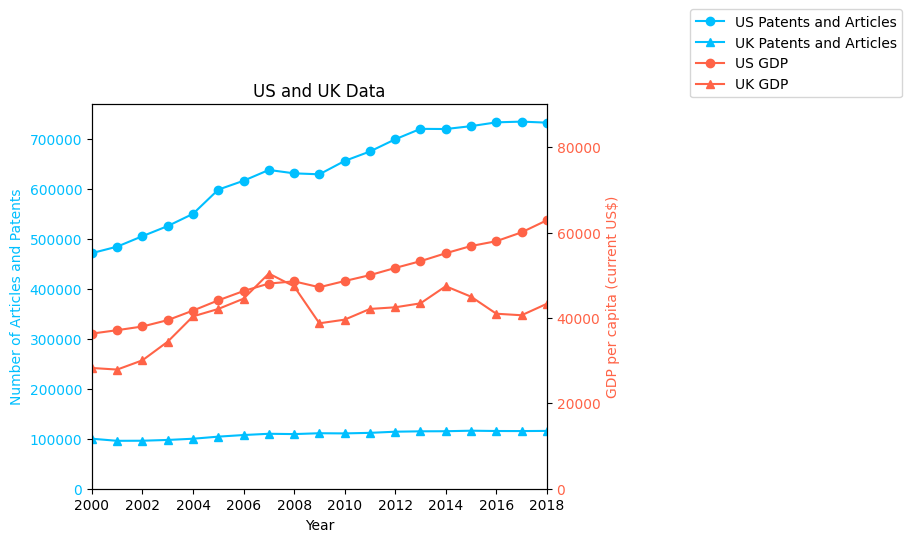

In [12]:
fig, ax1 = plt.subplots()

# Left y-axis
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of Articles and Patents", color="deepskyblue")
ax1.plot(data_years, US_patentsandarticles, label="US Patents and Articles",
         marker="o", color="deepskyblue")
ax1.plot(data_years, UK_patentsandarticles, label="UK Patents and Articles",
         marker="^", color="deepskyblue")
ax1.tick_params(axis='y', labelcolor="deepskyblue")
ax1.set_ylim(bottom=0)

# Right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("GDP per capita (current US$)", color="tomato")
ax2.plot(data_years, US_gdp, label="US GDP", marker="o", color="tomato")
ax2.plot(data_years, UK_gdp, label="UK GDP", marker="^", color="tomato")
ax2.tick_params(axis='y', labelcolor="tomato")
ax2.set_ylim(bottom=0)

# Main title, layout, and x-limits
plt.title("US and UK Data")
plt.xlim(2000, 2018)
fig.tight_layout()

# Combine legends from both axes
lines_labels = [ax.get_legend_handles_labels() for ax in (ax1, ax2)]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
plt.legend(lines, labels, bbox_to_anchor=(1.3, 1), ncol=1)

# Finally, show the plot
plt.show()